# Cleaning Data

### Down below we read all the provided data and save them as a dataframe

In [2]:
import pandas as pd 
import networkx as nx
from collections import OrderedDict
import pickle
import matplotlib.pyplot as plt
import numpy as np
import time 

In [3]:
with open("USA-road-d.CAL.gr","r") as f:
    text=f.readlines()
text=text[7:]
text=[list(map(int,dist[2:-1].split())) for dist in text]
df_distance=pd.DataFrame(text,columns=["from","to","dist"])
df_distance.head()

,from,to,dist
0,1,1048577,456
1,1048577,1,456
2,2,1048578,2389
3,1048578,2,2389
4,3,1048579,358


In [4]:
with open("USA-road-d.CAL.co","r") as f:
    text=f.readlines()
text=text[7:]
text=[list(map(int,dist[2:-1].split())) for dist in text]
df_cor=pd.DataFrame(text,columns=["Id_Node", "Latitude", "Longitude"])
df_cor.set_index("Id_Node",inplace=True)
df_cor.head()

,Latitude,Longitude
Id_Node,,
1,-114315309,34133550
2,-114223946,34176221
3,-114307299,34148791
4,-114318765,34138889
5,-114347300,34042614


In [5]:
with open("USA-road-t.CAL.gr","r") as f:
    text=f.readlines()
text=text[7:]
text=[list(map(int,dist[2:-1].split())) for dist in text]
df_time_distance=pd.DataFrame(text,columns=["from", "to", "time"])
df_time_distance.head()

,from,to,time
0,1,1048577,1139
1,1048577,1,1139
2,2,1048578,5972
3,1048578,2,5972
4,3,1048579,895


In [6]:
#Merging all dataframe into single one 
new_df=df_distance.merge(df_time_distance,left_index=True,right_index=True).drop(["from_y","to_y"],axis=1)
new_df.rename(columns={"from_x":"from","to_x":"to"},inplace=True)
new_df=new_df.iloc[[i for i in range(0,new_df.shape[0],2)]]
new_df.reset_index(drop=True,inplace=True)
new_df.head()

,from,to,dist,time
0,1,1048577,456,1139
1,2,1048578,2389,5972
2,3,1048579,358,895
3,4,1048579,14901,37253
4,5,6,18133,45332


## Our own Data Structure

### Here we create a dictionary which holds nodes as a key. And we assign node_attr , neighbors, edge_attr values for each nodes. node_attr holds location of each node , neighbors holds the neighbourhood of specific node. edge_attr holds the distance between given nodes and its neighbourhood. Below you can see an example for node 2 :
 
 {'node_attr': {'Latitude': -114223946, 'Longitude': 34176221},
 'neigbors': [1050174, 1048578, 2462],
 'edge_attr': {1050174: {'distance': 390, 'time': 975, 'network_distance': 1},
  1048578: {'distance': 2389, 'time': 5972, 'network_distance': 1},
  2462: {'distance': 558, 'time': 1394, 'network_distance': 1}}}


In [ ]:
graph={}
for idx,row in df_cor.iterrows():
    neigbors=[]
    time_seq=[]
    roi=new_df[(new_df["from"]==idx) |(new_df["to"]==idx)]
    for values in roi[roi["from"]!= idx].values:
        neigbors.append(values[0])
        time_seq.append((values[2],values[3]))
    for values in roi[roi["to"]!=idx].values:
        neigbors.append(values[1])
        time_seq.append((values[2],values[3]))
    graph[idx]={"node_attr":row.to_dict(),"neigbors":neigbors,"edge_attr":{i:{"distance":time[0],"time":time[1]} for i,time in zip(neigbors,time_seq)}}
    if idx%1000 == 0:
        print(idx)
    

In [470]:
## Creating this data structure takes nearly 8 hours. Thats why we save it as a pickle file for future usage.
with open('filename.pickle', 'wb') as handle:
    pickle.dump(graph, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
## Reading pickle file 
with open('filename.pickle', 'rb') as handle:
    graph = pickle.load(handle)

In [8]:
## resulting data structure for node 2 
graph[2]

{'node_attr': {'Latitude': -114223946, 'Longitude': 34176221},
 'neigbors': [1050174, 1048578, 2462],
 'edge_attr': {1050174: {'distance': 390, 'time': 975, 'network_distance': 1},
  1048578: {'distance': 2389, 'time': 5972, 'network_distance': 1},
  2462: {'distance': 558, 'time': 1394, 'network_distance': 1}}}

## Function 1 

In [11]:
def neighbours(location,threshold,distance_type):
    start=time.time()
    threshold=threshold
    #here we create dictionary,distance_dict,key values are nodes number and as a value it holds distance.For
    #initial values we start with threshold** 5(we can interpret it as infinity)
    distance_dict={i:threshold**5 for i in range(1,len(graph)+1)}
    ## setting given location distance as 0 
    distance_dict[location]=0
    ## checking list holds the neighbours that must be checked. As a initial status checking 
    checking=[location]
    ## if there is nothing to check break
    while len(checking)>0:
        another=[]
        # for each node that must be check do the followings:
        for node in checking:
            # find the neighbours of each node and if the distance is less then thereshold
            #update its distances value at distance_dict and then add this neigbours to the 
            #cheking list for the next step
            for neigh in graph[node]["neigbors"]:
                distance=distance_dict[node] + graph[node]["edge_attr"][neigh][distance_type]
                if distance<=threshold:
                    if distance_dict[neigh]> distance:
                        another.append(neigh)
                        distance_dict[neigh]=distance    
                else:
                    continue
        # update checking list
        checking=list(another)
    end=time.time()
    print(end-start)
    #return the value 
    return [nodes for nodes in distance_dict if distance_dict[nodes]<=threshold]

In [12]:
location=int(input("Give me your starting node--->"))
threshold=int(input("Give me your threshold--->"))
distance_type=input("Give me your distance_type{distance,time,network_distance}-->")
nodes=neighbours(location=location,threshold=threshold,distance_type=distance_type)
print("Total number of nodes -->",len(nodes))

Give me your starting node--->2
Give me your threshold--->300
Give me your distance_type{distance,time,network_distance}-->network_distance
3.263944625854492
Total number of nodes --> 67463


##  Visualization 1 - Visualize the Neighbours! 

### For visulization we use networkx. Firstafull we create networkx graph from all the nodes by using our merged dataframe.

In [9]:
G=nx.Graph()
for idx,rows in df_cor.iterrows():
    G.add_node(idx,attr_dict=rows.to_dict())
    

In [10]:
for idx,rows in new_df.iterrows():
    G.add_edge(rows.iloc[0],rows.iloc[1],dist=rows.iloc[2],time=rows.iloc[3])
nx.set_edge_attributes(G,1,"network_distance")    

### But for our visulization function we create a subgraph from graph G ,by using the output of neighbours function. 

In [13]:
def visualization(nodes,location):
    I=G.subgraph(nodes)
    for node in I.nodes():
        I.nodes[node]['pos'] = ( I.nodes[node]['attr_dict']['Longitude'] , I.nodes[node]['attr_dict']['Latitude'] )
        if node == location:
            I.nodes[node]['col'] = ("darkorange")
            I.nodes[node]['size'] = (5000)
            I.nodes[node]["alpha"]= (1)
        else: 
            I.nodes[node]['col'] = ("cornflowerblue")
            I.nodes[node]['size'] = (50)
            I.nodes[node]["alpha"]= (0.2)
    plt.clf()
    plt.figure(figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
    nx.draw_networkx_nodes(I, nx.get_node_attributes(I, 'pos'), 
                           node_color=list(nx.get_node_attributes(I, 'col').values()),node_shape='.',
                           node_size=list(nx.get_node_attributes(I, 'size').values()),
                           alpha=list(nx.get_node_attributes(I,"alpha").values()),
                           )
    nx.draw_networkx_edges(I, nx.get_node_attributes(I, 'pos'), width=0.2, alpha=0.7)
    plt.title("Orange one is the specified node")
    plt.show()

C:\Users\vedat\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


<Figure size 432x288 with 0 Axes>

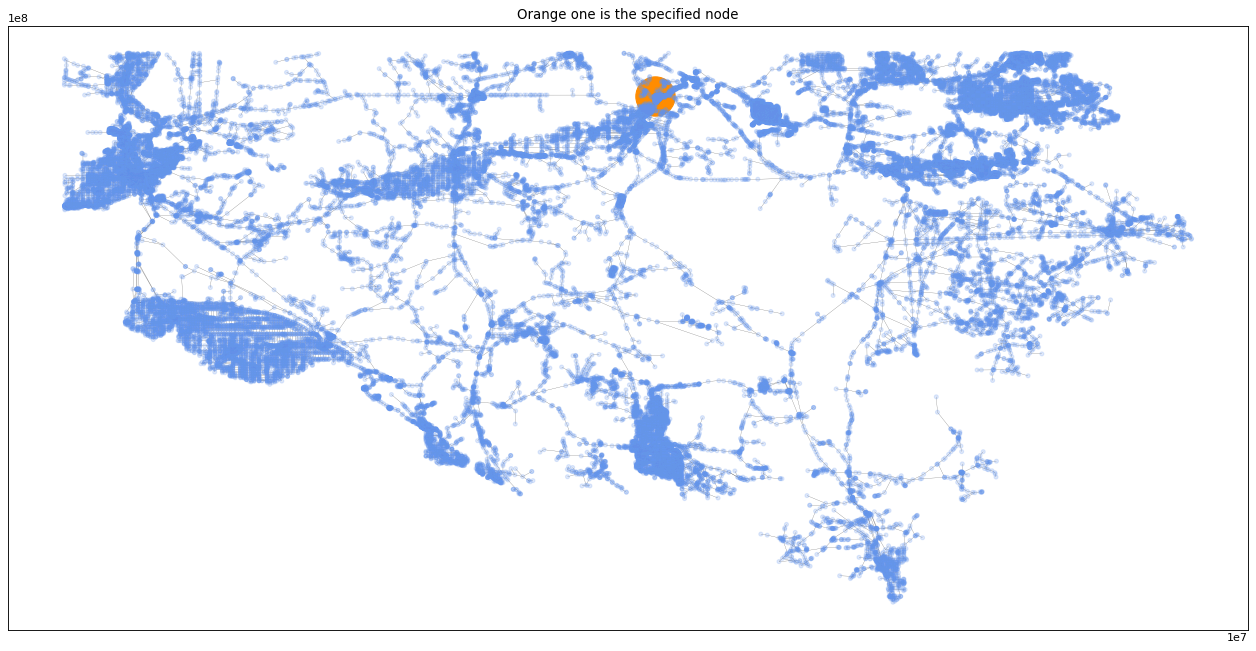

In [14]:
visualization(nodes,location)

## Function 4

We have implemented our own heuristic here. In our heuristic we first implement dijkstra algorithm between each node and store them in dataframe. Then we choose node which has the minimum distance between starting node. And then we do the same procedure to the selected node and we keep going like that until whole given node covered.

In [228]:
path_dictionary={}
def heuristic(interval_nodes,distance_type):
    interval_nodes=interval_nodes
    np_ones=np.ones((len(interval_nodes),len(interval_nodes)),dtype=np.float64)
    for firs_one in range(len(interval_nodes)):
        for second_one in range(len(interval_nodes)):
            if firs_one == second_one:
                np_ones[second_one,firs_one]=2**32
            else:
                distance=0
                path=nx.dijkstra_path(G,interval_nodes[firs_one],interval_nodes[second_one],weight=distance_type)
                start=path[0]
                for node in path[1:]:
                    distance += G[start][node][distance_type]
                    start=node
                np_ones[firs_one][second_one]=distance
                np_ones[second_one][firs_one]=distance
                path_dictionary[(interval_nodes[firs_one],interval_nodes[second_one])]={"path":path,"distance":distance}
                path_dictionary[(interval_nodes[firs_one],interval_nodes[second_one])]={"path":path,"distance":distance}
    return np_ones,interval_nodes
np_ones,interval_nodes=heuristic([1,3, 4, 5],"dist")[0],heuristic([1,3, 4, 5],"dist")[1]


In [229]:
data_frame=pd.DataFrame(np_ones,columns=interval_nodes,index=interval_nodes)
data_frame

,1,3,4,5
1,4.294967e+09,1.858000e+04,1.010400e+04,1.211990e+05
3,1.858000e+04,4.294967e+09,1.525900e+04,1.397790e+05
4,1.010400e+04,1.525900e+04,4.294967e+09,1.308010e+05
5,1.211990e+05,1.397790e+05,1.308010e+05,4.294967e+09


In [231]:
place_holder=interval_nodes[0]
xx=[]
distance=0
included_paths=[]
data_frame=pd.DataFrame(np_ones,columns=interval_nodes,index=interval_nodes)
while len(xx)<len(interval_nodes):
    
    bind=data_frame.loc[:,place_holder].idxmin()
    included_paths.append((place_holder,bind))
    for path in path_dictionary[(place_holder,bind)]["path"]:
        if path in x and path not in xx:
            xx.append(path)
    distance+=data_frame.loc[bind,place_holder]
    data_frame=data_frame.drop(place_holder,axis=1)
    data_frame=data_frame.drop(place_holder,axis=0)
    place_holder=bind
    

In [232]:
route=[]
for path in included_paths:
    [route.append(i) for i in path_dictionary[path]["path"]]

In [233]:
def visualization(nodes):
    I=G.subgraph(nodes)
    for node in I.nodes():
        I.nodes[node]['pos'] = ( I.nodes[node]['attr_dict']['Longitude'] , I.nodes[node]['attr_dict']['Latitude'] )
        I.nodes[node]['col'] = ("cornflowerblue")
        I.nodes[node]['size'] = (500)
    plt.clf()
    plt.figure(figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
    nx.draw_networkx_nodes(I, nx.get_node_attributes(I, 'pos'), 
                           node_color=list(nx.get_node_attributes(I, 'col').values()),node_shape='.',
                           node_size=list(nx.get_node_attributes(I, 'size').values()))
    nx.draw_networkx_edges(I, nx.get_node_attributes(I, 'pos'), width=1)
    plt.title("Orange one is the specified node")
    plt.show()

C:\Users\vedat\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


<Figure size 432x288 with 0 Axes>

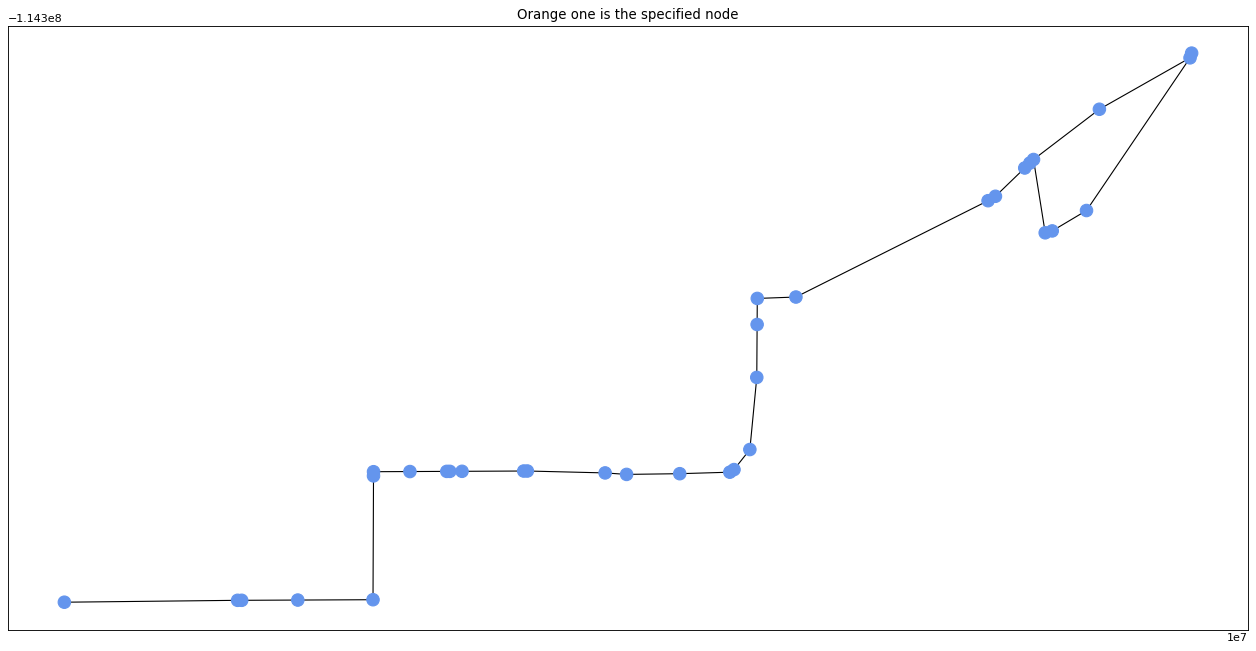

In [234]:
visualization(route)